# Sentiment Analysis - LinearSVM

## Import

In [1]:
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, f1_score,ConfusionMatrixDisplay
import spacy

# Load Dataset

In [2]:
train_path = "sentiment_data.csv"
test_path = "sentiment-topic-test.tsv"
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path, sep='\t')

# function to clean text
def clean_text(sentence, remove_stopwords_and_lemmatize=False):
    # remove digits, punctuations, special chars and extra spaces
    sentence = re.sub(r'[^a-zA-Z! ]+', '', sentence)
    sentence = re.sub(r'\s+', ' ', sentence).strip()
    return sentence

# get cleaned train and test sentences
xtrain = train_data['Sentence'].apply(clean_text)
xtest = test_data['sentence'].apply(clean_text)

# get encoded labels according to hugging face documentation
label_map = {'positive': 2, 'negative': 0, 'neutral': 1}
ytrain = train_data['Sentiment'].map(lambda x: label_map[x])
ytest = test_data['sentiment'].map(lambda x: label_map[x])

# Visualize Train and Test Data Distribution


Instances in training data: 5842. Instances in test data: 18


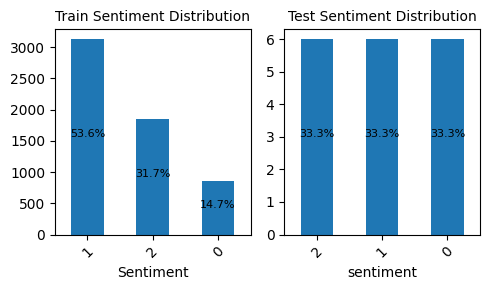

In [3]:

print(f"Instances in training data: {len(xtrain)}. Instances in test data: {len(xtest)}")

# plot the distribution of instances in train and test data
label_counts_test =  ytest.value_counts()
label_counts_train =  ytrain.value_counts()
fig, axes = plt.subplots(1, 2, figsize=(5, 3))

# Train plot
label_counts_train.plot(kind='bar', ax=axes[0])
axes[0].set_title("Train Sentiment Distribution", fontsize=10)
axes[0].tick_params(axis='x', rotation=45)
for i, v in enumerate(label_counts_train):
    pct = f"{(v / label_counts_train.sum()) * 100:.1f}%"
    axes[0].text(i, v * 0.5, pct, ha='center', fontsize=8)

# Test plot
label_counts_test.plot(kind='bar', ax=axes[1])
axes[1].set_title("Test Sentiment Distribution", fontsize=10)
axes[1].tick_params(axis='x', rotation=45)
for i, v in enumerate(label_counts_test):
    pct = f"{(v / label_counts_test.sum()) * 100:.1f}%"
    axes[1].text(i, v * 0.5, pct, ha='center', fontsize=8)

plt.tight_layout()
plt.show()

# Model building - LinearSVM
### arguments:
penalty: l1,
loss: squared_hinge,
multy_class: ovr,
class_weight: balanced,
max_iter: 5000,
C:1.2

In [4]:
vectorizer = TfidfVectorizer(max_features=5000)

X_train_raw = vectorizer.fit_transform(xtrain)
X_test_raw = vectorizer.transform(xtest)

In [5]:
model = LinearSVC(
    penalty='l1',
    loss='squared_hinge',
    dual=False,
    multi_class='ovr',
    class_weight='balanced',
    max_iter=5000,
    C=1.2,
    tol=2e-4
)
# model.fit(X_train, ytrain)

In [6]:
nlp = spacy.load("en_core_web_sm")
english_stopwords = set(stopwords.words('english'))

def remove_stopwords_and_lemmatize(sentence):
    doc = nlp(sentence)
    sentence = " ".join([token.lemma_ for token in doc if token.text not in english_stopwords])
    return sentence

def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    # true labels and predicted labels
    y_pred = model.predict(X_test)

    # compute metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')

    # print detailed classification report
    print("Classification Report:\n", classification_report(y_test, y_pred, digits=3,target_names= label_map,zero_division=np.nan))
    print(f"Accuracy: {acc:.3f}")
    print(f"Macro F1: {f1:.3f}")

    # create a confusion matrix to display the distribution of predictions
    ConfusionMatrixDisplay.from_predictions(ytest, y_pred,display_labels=label_map)
    plt.show()

xtrain_lemmatized = xtrain.apply(remove_stopwords_and_lemmatize)
xtest_lemmatized = xtest.apply(remove_stopwords_and_lemmatize)

/opt/anaconda3/envs/tmvu/lib/python3.12/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.8.0) was trained with spaCy v3.8.0 and may not be 100% compatible with the current version (3.7.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


# Experiment 1: Without stop word removal and lemmatization


Classification Report:
               precision    recall  f1-score   support

    positive      0.000     0.000     0.000         6
    negative      0.375     1.000     0.545         6
     neutral      1.000     0.167     0.286         6

    accuracy                          0.389        18
   macro avg      0.458     0.389     0.277        18
weighted avg      0.458     0.389     0.277        18

Accuracy: 0.389
Macro F1: 0.277


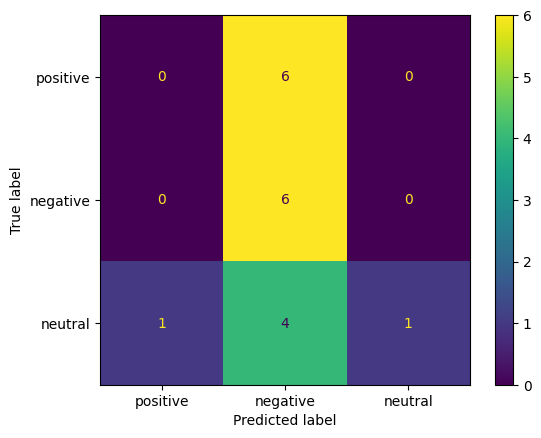

In [7]:
evaluate_model(model, X_train_raw, X_test_raw, ytrain, ytest)


# Experiment 2: With stop word removal and lemmatization


Classification Report:
               precision    recall  f1-score   support

    positive        nan     0.000     0.000         6
    negative      0.333     0.833     0.476         6
     neutral      0.667     0.333     0.444         6

    accuracy                          0.389        18
   macro avg      0.500     0.389     0.307        18
weighted avg      0.500     0.389     0.307        18

Accuracy: 0.389
Macro F1: 0.307


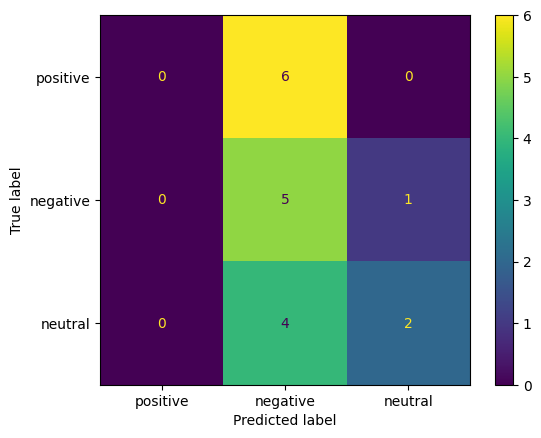

In [8]:
X_train_lem = vectorizer.fit_transform(xtrain_lemmatized)
X_test_lem = vectorizer.transform(xtest_lemmatized)
evaluate_model(model, X_train_lem, X_test_lem, ytrain, ytest)